##########
importing data of : B4_1_A
The chosen lambda is  29.76351441631318


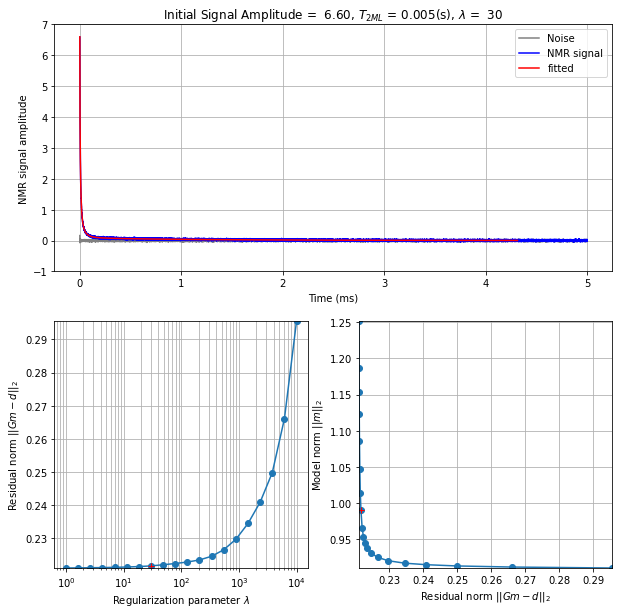

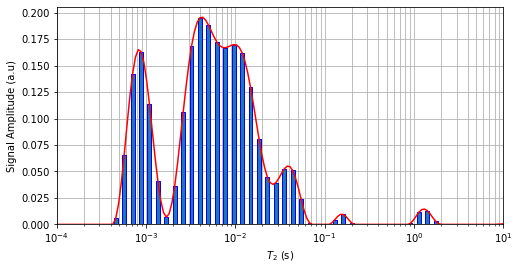

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os.path
import math
%matplotlib inline

# user defined functions
from t2nnls import T2NNLS
from getT2LogMean import getT2LogMean
from getLambdaFromRMSE import getLambdaFromRMSE
from pltLcurve import pltLambdaRMS, pltLcurve
from pltRTD import pltT2dist

def RawNMR(df,ax):    
    temp_df = np.array(df)
    time = temp_df[:,0]/1000
    data = temp_df[:,1]
    noise = temp_df[:,2]
    
    ax.plot(time,noise,color = 'gray', label = 'Noise')
    ax.plot(time,data, color = 'blue', label = 'NMR signal')

    x = data
    y = noise
    z = data + 1j*noise

    temp_zphase = np.angle(z)
    ztheta = np.mean(temp_zphase[0:19])
    z = z*np.exp(-1j*ztheta)
    noise = z.imag
    data = z.real 
    
    return time, data, noise

if __name__ == "__main__":       
    fileDir = 'D:/Github/invRCA/example-data/'
    sampleName = 'B4_1_A'
    csvFile = 'Group1/T2CPMG_200/1/data.csv'
    dataDir = os.path.join(fileDir, sampleName, csvFile) 
    df = pd.read_csv(dataDir, sep = ',',header = None)  
    print("##########")
    print('importing data of :', sampleName)  
    
    fig = plt.figure(figsize = (10, 10))
    ax0 = fig.add_subplot(211)  
    
    time, data, noise = RawNMR(df, ax0) # plot raw NMR signal measured by RCA
    
    lambDa = np.geomspace(1, 10000, 20) # predifined lambda values   
    T2 = np.logspace(-4, 1, num = 160).transpose() # predefined T2 values
    rmse = np.zeros(len(lambDa))
    modelnorm = np.zeros(len(lambDa))

    for lambDa_index in range(len(lambDa)):
        (m,r,dsyn,rnorm) = T2NNLS(data,time,noise,T2,lambDa[lambDa_index], 100) # set the winsize = 100
        rmse[lambDa_index] = r[0] # residual norm
        modelnorm[lambDa_index] = r[1] # model norm        
    # get the reg. parameter
    index = getLambdaFromRMSE(lambDa, rmse) 
    
    # use the lambda value to get the inverted model data
    (m,r,dsyn,rnorm) = T2NNLS(data,time,noise,T2,lambDa[index], 100)
    
    ax0.plot(dsyn[:,0], dsyn[:,1], '-', color = 'r', label='fitted')    
    ax0.set_ylim(math.floor(min(data)), math.ceil(max(data)))
    ax0.grid(True, which='both')
    ax0.set_xlabel('Time (ms)')
    ax0.set_ylabel('NMR signal amplitude')
    ax0.legend(loc='best')
    
    maxFit = np.max(dsyn[:,1])
    T2ml = getT2LogMean(T2, m[:-1])
    
    ax0.set_title("Initial Signal Amplitude = %5.2f, $T_{2ML}$ = %5.3f(s), $\lambda$ = %3.0f" %(maxFit,T2ml,lambDa[index]))
    
    # plot lambda vs RMS with determiend lambDa
    ax1 = fig.add_subplot(223)  
    pltLambdaRMS(lambDa, rmse, index, ax1)
    ax2 = fig.add_subplot(224)
    pltLcurve(rmse, modelnorm, index, ax2)     
    fig.savefig(os.path.join(fileDir, sampleName + '_nnls.png'),bbox_inches='tight')  
    
    fig_t2 = plt.figure(figsize = (8, 4))
    ax_t2 = fig_t2.add_subplot(111)
    pltT2dist(T2, m[:-1], ax_t2)
    fig_t2.savefig(os.path.join(fileDir, sampleName + '_T2dist.png'),bbox_inches='tight')  
    
    plt.show()